In [69]:

from pathlib import Path
import cv2

images = [cv2.imread(str(x)) for x in Path("images").iterdir()]

In [70]:
from time import time

def measure(func):
    def inner(image, detector):
        start = time()
        output = func(image, detector)
        return (time() - start) * 1000 / output[0], output[1]
    return inner

@measure
def detect(image, detector):
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return len(keypoints), descriptors
    

In [71]:
data = {
    "surf": {
        "detector": cv2.xfeatures2d.SURF_create(), 
        "norm": cv2.NORM_L2,
        "descriptors": []
    },
    "sift": {
        "detector": cv2.SIFT_create(), 
        "norm": cv2.NORM_L2,
        "descriptors": []
    },
    "brisk": {
        "detector": cv2.BRISK_create(), 
        "norm": cv2.NORM_HAMMING,
        "descriptors": []
    }
}


In [72]:
import numpy as np

for detector_name in data:
    times = []
    for i in range(len(images)):
        curr_time, descriptors = detect(images[i], data[detector_name]["detector"])
        data[detector_name]["descriptors"].append(descriptors)
        times.append(curr_time)
    print(f"Detector: {detector_name}, average time: {sum(times) / len(times)} ms")  
    

Detector: surf, average time: 0.015597778424514203 ms
Detector: sift, average time: 0.01838400747216758 ms
Detector: brisk, average time: 0.014335369960418953 ms


In [73]:
def get_repeatabilities(descriptors, norm):   
    bruteforce = cv2.BFMatcher_create(norm, crossCheck=True)
    repeatabilities = []
    for i in range(len(descriptors)):
        matches_count = 0
        for j in range(len(descriptors)):
            matches = bruteforce.match(descriptors[i], descriptors[j])
            matches_count += len(matches)
        repeatabilities.append(matches_count / len(descriptors[i]) / len(descriptors))
    return repeatabilities

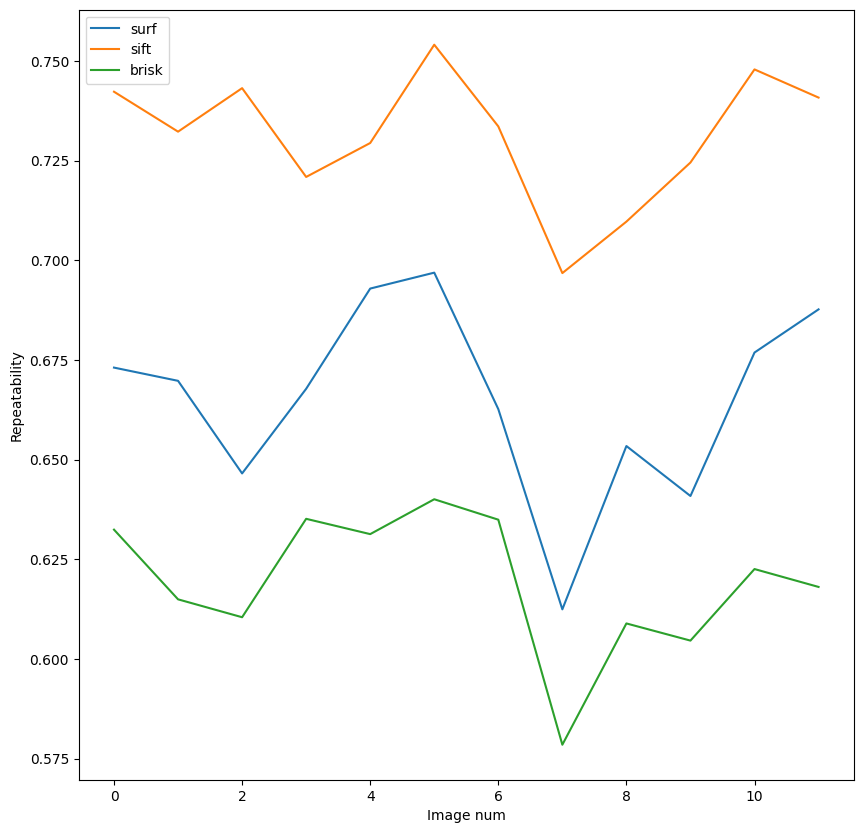

In [77]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))

for detector_name in data:
    plt.plot(get_repeatabilities(data[detector_name]["descriptors"], data[detector_name]["norm"]), label=detector_name)

plt.xlabel("Image num")
plt.ylabel("Repeatability")
plt.legend()
plt.show()